# **Parties in Power (PiP) Master Notebook**

---

**Created**: 15/03/2025  
**Purpose**: To create visualisations for the PiP article **(ADD LINK HERE)**  
**Prerequisites**: Data preparation notebooks to be run for each country **(ADD LINK HERE)**  
**Output**: JPEG-format visualisations for: 1) Change in political alignment by popular vote; 2) Change in political alignment by party in power.

---

## **Import Required Libraries**

In [1]:
# Import pandas
import pandas as pd

# Import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import os to access directories
import os

# Import json for config files
import json

## **Import Processed Data**

### **Define Folder Path for Processed Data**

In [2]:
# Define main directory & config filepath
main_directory = os.path.abspath(os.path.join(os.getcwd(), '..\..'))  # Go up one level to the main directory

# Define folder path for processed election data
inp_path = os.path.join(main_directory, '03. Output\\01. Intermediate\\')

### **Create Dictionary of Election Results for Each Country**

In [3]:
# Get all CSV files in the directory
csv_files = [f for f in os.listdir(inp_path) if f.endswith('.csv')]

# Dictionary to store paired DataFrames
country_dict = {}

# Iterate through files and store them in dictionary
for file in csv_files:
    country, version = file.rsplit("_", 1)  # Split into country and version (e.g., "UK", "Prev.csv")
    version = version.replace(".csv", "")  # Remove ".csv"

    # Read CSV into DataFrame
    df = pd.read_csv(f"{inp_path}\{file}")

    # Initialize country key if not exists
    if country not in country_dict:
        country_dict[country] = {}

    # Store the DataFrame under "Prev" or "New"
    country_dict[country][version] = df

## **Create Master Dataframe**

### **Join All Dataframes**

In [4]:
# Initialise list of rows for master_df
master_lst = []

# Loop through all dfs
for country, df_dict in country_dict.items():
    # Extract prev and new dfs
    prev_df = df_dict["Prev"]
    new_df = df_dict["New"]

    # Order dfs by Vote Prop
    prev_df = prev_df.sort_values("In-Scope Vote Prop", ascending=False).reset_index(drop=True)
    new_df = new_df.sort_values("In-Scope Vote Prop", ascending=False).reset_index(drop=True)

    # Compute Political Spectrum Scores (dot product of Alignment and In-Scope Vote Prop)
    prev_score = prev_df["Alignment Score"].dot(prev_df["In-Scope Vote Prop"])
    new_score = new_df["Alignment Score"].dot(new_df["In-Scope Vote Prop"])

    # Get alignment of majority party for each election
    prev_party = prev_df["Alignment Score"][0]
    new_party = new_df["Alignment Score"][0]
    
    # Append the results as a new row in the master list
    master_lst.append({
        "Country": country, 
        "Previous Political Spectrum Score": prev_score, 
        "Latest Political Spectrum Score": new_score,
        "Previous Majority Party": prev_party,
        "Latest Majority Party": new_party
    })

# Create master DataFrame
master_df = pd.DataFrame(master_lst)

### **Create Alignment Change Column**

In [5]:
# Create alignment change col
master_df["Alignment Change"] = master_df["Latest Political Spectrum Score"] - master_df["Previous Political Spectrum Score"]

# Sort by biggest change (from left to right) asc
master_df = master_df.sort_values("Latest Political Spectrum Score", ascending=True).reset_index(drop=True)

# Convert 'Country' column to categorical for correct plotting order
master_df['Country'] = pd.Categorical(master_df['Country'], categories=master_df['Country'], ordered=True)

# Display the final master DataFrame
master_df

,Country,Previous Political Spectrum Score,Latest Political Spectrum Score,Previous Majority Party,Latest Majority Party,Alignment Change
0,UK,0.430000,0.070000,3,-2,-0.360000
1,Canada,0.084484,0.232640,-1,-1,0.148156
2,Belgium,0.207070,0.255894,2,2,0.048825
3,Australia,0.759323,0.346381,3,3,-0.412942
4,US,0.392500,0.517513,-2,3,0.125013
5,Sweden,0.608662,0.693772,-2,-2,0.085110
6,Italy,-0.484269,0.830414,-4,5,1.314683
7,Germany,0.628578,0.946423,2,2,0.317845
8,Netherlands,1.125280,1.469460,2,5,0.344180
9,France,0.544989,1.535629,1,6,0.990640


## **Create Visualisations**

### **Set Custom Font**

In [6]:
from matplotlib.font_manager import fontManager, FontProperties

path = r"C:\Users\josha\OneDrive\Attachments\Documents\Data Science Blog\cabin\Cabin-Bold.ttf"
fontManager.addfont(path)

prop = FontProperties(fname=path)
sns.set_theme(font=prop.get_name())

### **Test**

In [87]:
import matplotlib as mpl
import matplotlib.style as style

# Set the theme
style.use('fivethirtyeight')

#
mpl.rcParams['axes.facecolor'] = '#212528'
mpl.rcParams['figure.facecolor'] = '#212528'
mpl.rcParams['grid.color'] = 'white'
mpl.rcParams['grid.alpha'] = 1
mpl.rcParams['xtick.labelcolor'] = 'white'
mpl.rcParams['ytick.labelcolor'] = 'white'

C:\Users\josha\AppData\Local\Temp\ipykernel_21832\4025603305.py:132: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


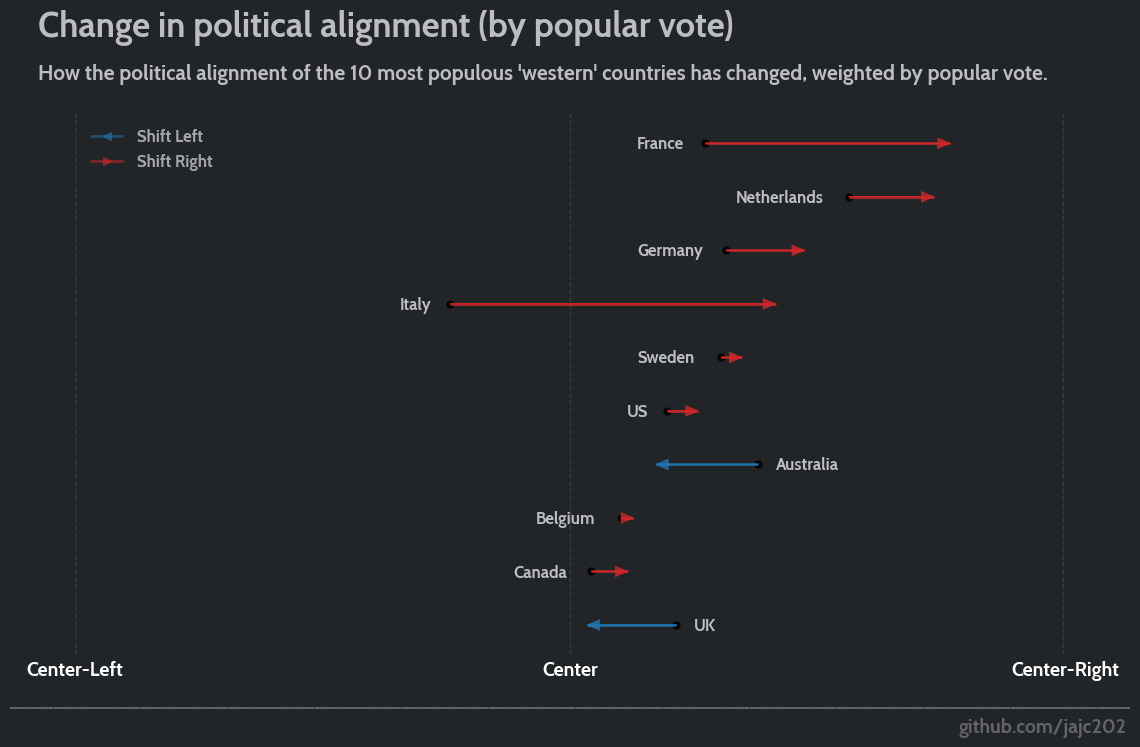

In [267]:
# Create a figure and an axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
left_shift_color = "#1f77b4"   # Muted blue (leftward shift)
right_shift_color = "#d62728"  # Muted red (rightward shift)
marker_edge_color = "black"

# Loop through each country and plot the shift
for i in range(len(master_df)):
    prev_score = master_df["Previous Political Spectrum Score"][i]
    latest_score = master_df["Latest Political Spectrum Score"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_score < prev_score else right_shift_color
    
    # Plot connecting line
    ax.plot([prev_score, latest_score], [country, country], 
             color=line_color, linestyle="-", linewidth=2, alpha=0.8)

    # Plot previous score marker
    ax.scatter(prev_score, country, 
                color=marker_edge_color, s=25, label="Previous Score" if i == 0 else "", 
                edgecolor=marker_edge_color, linewidth=0.8)
    
    # Plot latest score marker
    #plt.scatter(latest_score, country, 
    #            color=marker_edge_color, s=25, label="Latest Score" if i == 0 else "", 
    #            edgecolor=marker_edge_color, linewidth=0.8)

    # Add an arrow showing direction
    ax.arrow(prev_score, i, latest_score - prev_score, 0, 
              head_width=0.2, head_length=0.05, 
              color=line_color, alpha=0.8, length_includes_head=True)
    
# Add a vertical center line for reference
ax.axvline(0, color="white", linestyle="--", linewidth=1, alpha=0.1)
ax.axvline(-2, color="white", linestyle="--", linewidth=1, alpha=0.1)
ax.axvline(1.99, color="white", linestyle="--", linewidth=1, alpha=0.1)

# The signature bar
ax.text(x = 2.25, y = -2,
    s = 'github.com/jajc202',fontsize = 14, color = 'grey', alpha = .7, ha='right')

# The other signature bar
ax.text(x = 0, y = -1.5,
    s = '_______________________________________________________________________________________________________',
    color = 'grey', alpha = .7, ha='center')

# The signature bar
ax.text(x = -2.15, y = 11,
    s = 'Change in political alignment (by popular vote)',fontsize = 25, color = 'white', alpha = .7, ha='left')

# The signature bar
ax.text(x = -2.15, y = 10.2,
    s = 'How the political alignment of the 10 most populous \'western\' countries has changed, weighted by popular vote.',fontsize = 15, color = 'white', alpha = .7, ha='left')

# UK
ax.text(x = 0.5, y = -0.1,
    s = 'UK',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Candada
ax.text(x = -0.23, y = 0.9,
    s = 'Canada',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Belgium
ax.text(x = -0.14, y = 1.9,
    s = 'Belgium',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Australia
ax.text(x = 0.83, y = 2.9,
    s = 'Australia',fontsize = 12, color = 'white', alpha = .7, ha='left')
# US
ax.text(x = 0.23, y = 3.9,
    s = 'US',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Sweden
ax.text(x = 0.27, y = 4.9,
    s = 'Sweden',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Italy
ax.text(x = -0.69, y = 5.9,
    s = 'Italy',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Germany
ax.text(x = 0.27, y = 6.9,
    s = 'Germany',fontsize = 12, color = 'white', alpha = .7, ha='left')
# Netherlands
ax.text(x = 0.67, y = 7.9,
    s = 'Netherlands',fontsize = 12, color = 'white', alpha = .7, ha='left')
# France
ax.text(x = 0.27, y = 8.9,
    s = 'France',fontsize = 12, color = 'white', alpha = .7, ha='left')


# Set margins
# Set labels and title
#plt.xlabel("Political Spectrum Score", fontsize=14, fontweight="bold")
plt.ylabel("")  # Remove y-axis label for a cleaner look
#plt.title("Political Alignment Shift by Country", fontsize=16, fontweight="bold")

# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=14)
plt.yticks([], [])

plt.xlim(-2, 2)

# Improve aesthetics
#plt.legend(fontsize=12, frameon=False)  # Simple legend
plt.gca().xaxis.grid(False)
sns.despine(left=True, bottom=True)  # Remove extra spines

# Adjust margins
fig.tight_layout()
fig.subplots_adjust(left=0.075, right=0.9)


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create legend elements
left_arrow = mlines.Line2D([], [], color=left_shift_color, marker='<', linestyle='-', linewidth=2, label="Shift Left")
right_arrow = mlines.Line2D([], [], color=right_shift_color, marker='>', linestyle='-', linewidth=2, label="Shift Right")

# Add legend to the plot
leg = ax.legend(handles=[left_arrow, right_arrow], loc="upper left", fontsize=12, frameon=False)

for lh in leg.legendHandles: 
    lh.set_alpha(0.5)

for ll in leg.texts: 
    ll.set_alpha(0.6)


# Show the plot
plt.show()

### **Change in Political Alignment by Popular Vote**

In [6]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

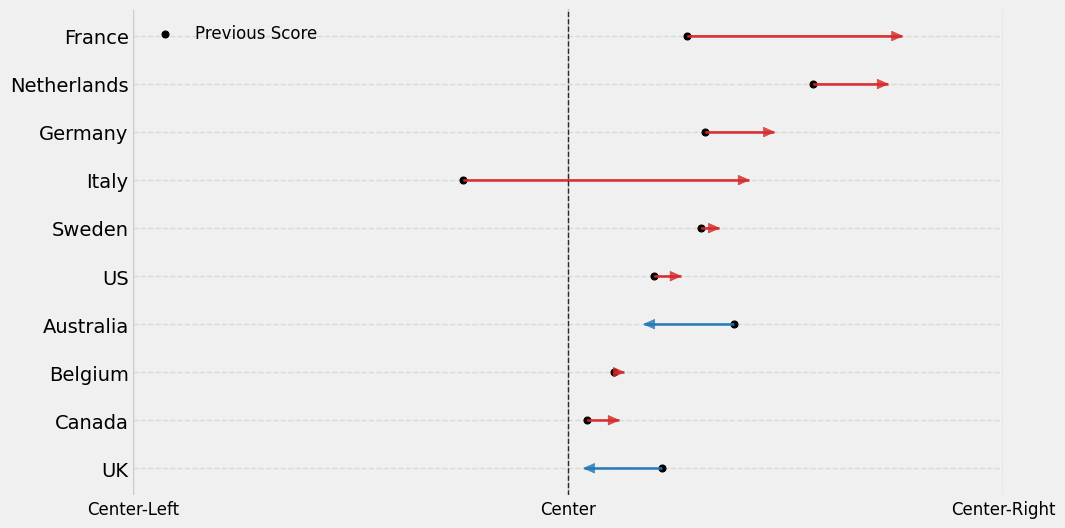

In [9]:
# Set the theme
style.use('fivethirtyeight')

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors
left_shift_color = "#1f77b4"   # Muted blue (leftward shift)
right_shift_color = "#d62728"  # Muted red (rightward shift)
marker_edge_color = "black"

# Loop through each country and plot the shift
for i in range(len(master_df)):
    prev_score = master_df["Previous Political Spectrum Score"][i]
    latest_score = master_df["Latest Political Spectrum Score"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_score < prev_score else right_shift_color
    
    # Plot connecting line
    plt.plot([prev_score, latest_score], [country, country], 
             color=line_color, linestyle="-", linewidth=2, alpha=0.8)

    # Plot previous score marker
    plt.scatter(prev_score, country, 
                color=marker_edge_color, s=25, label="Previous Score" if i == 0 else "", 
                edgecolor=marker_edge_color, linewidth=0.8)
    
    # Plot latest score marker
    #plt.scatter(latest_score, country, 
    #            color=marker_edge_color, s=25, label="Latest Score" if i == 0 else "", 
    #            edgecolor=marker_edge_color, linewidth=0.8)

    # Add an arrow showing direction
    plt.arrow(prev_score, i, latest_score - prev_score, 0, 
              head_width=0.2, head_length=0.05, 
              color=line_color, alpha=0.8, length_includes_head=True)

# Add a vertical center line for reference
plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Set labels and title
#plt.xlabel("Political Spectrum Score", fontsize=14, fontweight="bold")
plt.ylabel("")  # Remove y-axis label for a cleaner look
#plt.title("Political Alignment Shift by Country", fontsize=16, fontweight="bold")

# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=12)

plt.xlim(-2, 2)

# Improve aesthetics
plt.legend(fontsize=12, frameon=False)  # Simple legend
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Subtle horizontal gridlines
sns.despine(left=True, bottom=True)  # Remove extra spines

# Show the plot
plt.show()


In [31]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

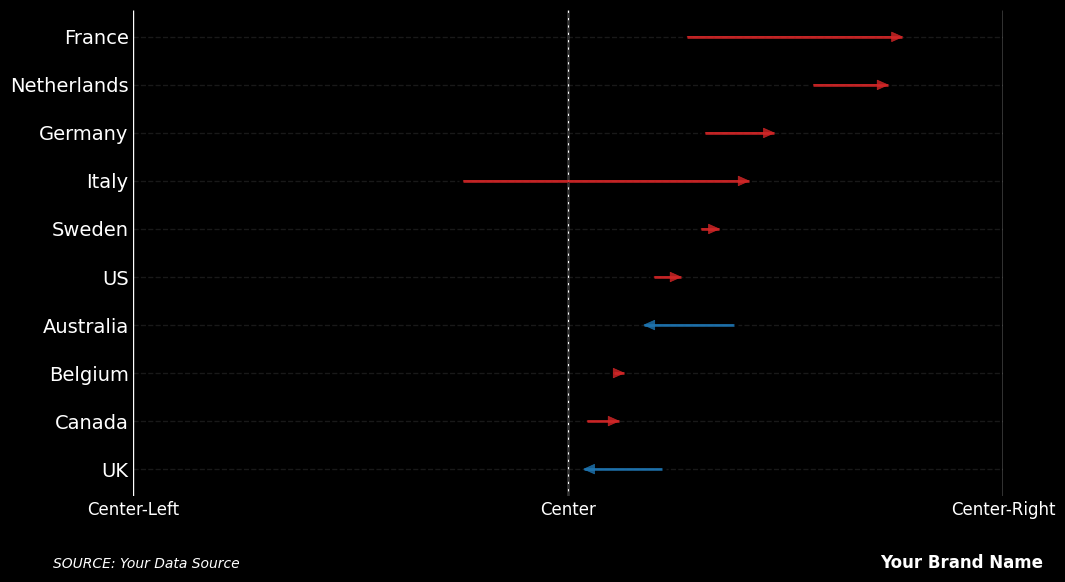

In [63]:
# Set the theme
style.use('dark_background')

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors
left_shift_color = "#1f77b4"   # Muted blue (leftward shift)
right_shift_color = "#d62728"  # Muted red (rightward shift)
marker_edge_color = "black"

# Loop through each country and plot the shift
for i in range(len(master_df)):
    prev_score = master_df["Previous Political Spectrum Score"][i]
    latest_score = master_df["Latest Political Spectrum Score"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_score < prev_score else right_shift_color
    
    # Plot connecting line
    plt.plot([prev_score, latest_score], [country, country], 
             color=line_color, linestyle="-", linewidth=2, alpha=0.8)

    # Plot previous score marker
    plt.scatter(prev_score, country, 
                color=marker_edge_color, s=25, label="Previous Score" if i == 0 else "", 
                edgecolor=marker_edge_color, linewidth=0.8)
    
    # Plot latest score marker
    #plt.scatter(latest_score, country, 
    #            color=marker_edge_color, s=25, label="Latest Score" if i == 0 else "", 
    #            edgecolor=marker_edge_color, linewidth=0.8)

    # Add an arrow showing direction
    plt.arrow(prev_score, i, latest_score - prev_score, 0, 
              head_width=0.2, head_length=0.05, 
              color=line_color, alpha=0.8, length_includes_head=True)

# Add a vertical center line for reference
plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Set labels and title
#plt.xlabel("Political Spectrum Score", fontsize=14, fontweight="bold")
plt.ylabel("")  # Remove y-axis label for a cleaner look
#plt.title("Political Alignment Shift by Country", fontsize=16, fontweight="bold")

# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=12)

plt.xlim(-2, 2)

# Improve aesthetics
#plt.legend(fontsize=12, frameon=False)  # Simple legend
plt.grid(axis="y", linestyle="--", alpha=0.1)  # Subtle horizontal gridlines
sns.despine(left=True, bottom=True)  # Remove extra spines

# Add a signature text
plt.figtext(0, -0.05, "SOURCE: Your Data Source", ha="left", fontsize=10, color="white", style='italic')
plt.figtext(0.99, -0.05, "Your Brand Name", ha="right", fontsize=12, fontweight="bold", color="white")

# Show the plot
plt.show()


AttributeError: 'Axes' object has no attribute 'facecolor'

C:\Users\josha\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\josha\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


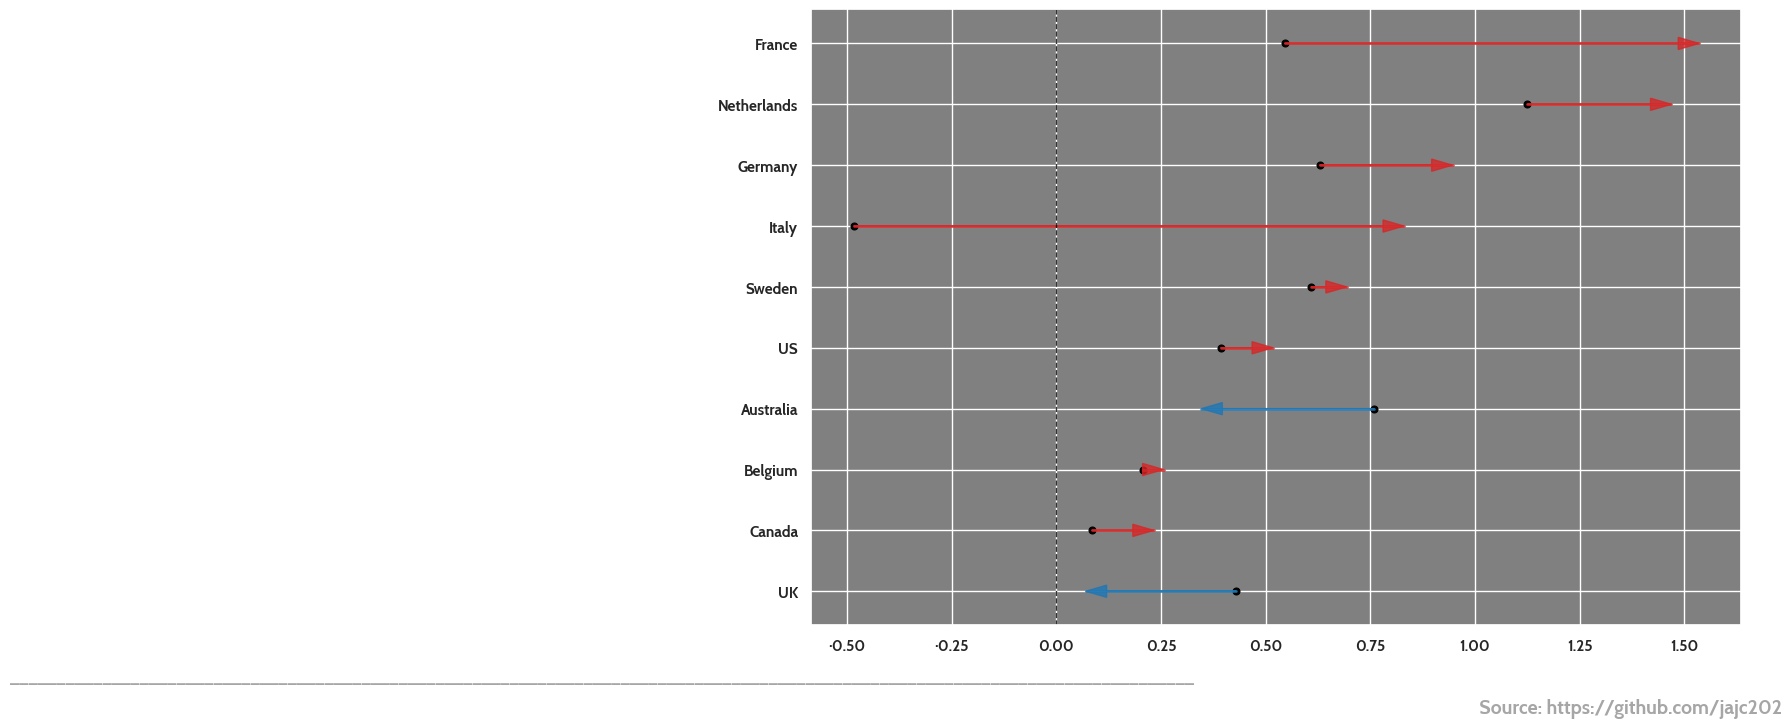

In [7]:
import matplotlib as mpl

# Set the theme
#style.use('seaborn-v0_8')

mpl.rcParams['axes.facecolor'] = 'grey'

# Create a figure and an axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
left_shift_color = "#1f77b4"   # Muted blue (leftward shift)
right_shift_color = "#d62728"  # Muted red (rightward shift)
marker_edge_color = "black"

# Loop through each country and plot the shift
for i in range(len(master_df)):
    prev_score = master_df["Previous Political Spectrum Score"][i]
    latest_score = master_df["Latest Political Spectrum Score"][i]
    country = master_df["Country"][i]
    
    # Determine line color based on direction of movement
    line_color = left_shift_color if latest_score < prev_score else right_shift_color
    
    # Plot connecting line
    ax.plot([prev_score, latest_score], [country, country], 
             color=line_color, linestyle="-", linewidth=2, alpha=0.8)

    # Plot previous score marker
    ax.scatter(prev_score, country, 
                color=marker_edge_color, s=25, label="Previous Score" if i == 0 else "", 
                edgecolor=marker_edge_color, linewidth=0.8)
    
    # Plot latest score marker
    #plt.scatter(latest_score, country, 
    #            color=marker_edge_color, s=25, label="Latest Score" if i == 0 else "", 
    #            edgecolor=marker_edge_color, linewidth=0.8)

    # Add an arrow showing direction
    ax.arrow(prev_score, i, latest_score - prev_score, 0, 
              head_width=0.2, head_length=0.05, 
              color=line_color, alpha=0.8, length_includes_head=True)
    
# Add a vertical center line for reference
ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# The signature bar
ax.text(x = 1, y = -2,
    s = ' Source: https://github.com/jajc202',fontsize = 14, color = 'grey', alpha = .7)

# The other signature bar
ax.text(x = -2.5, y = -1.5,
    s = '________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

ax.facecolor 

# Set labels and title
#plt.xlabel("Political Spectrum Score", fontsize=14, fontweight="bold")
plt.ylabel("")  # Remove y-axis label for a cleaner look
#plt.title("Political Alignment Shift by Country", fontsize=16, fontweight="bold")

# Define custom x-tick labels
x_tick_mapping = {
    -6: "Far-Left", 
    -4: "Left", 
    -2: "Center-Left", 
     0: "Center", 
     2: "Center-Right", 
     4: "Right", 
     6: "Far-Right"
}
plt.xticks(ticks=list(x_tick_mapping.keys()), labels=list(x_tick_mapping.values()), fontsize=12)

plt.xlim(-2, 2)

# Improve aesthetics
#plt.legend(fontsize=12, frameon=False)  # Simple legend
plt.grid(axis="y", linestyle="--", alpha=0.1)  # Subtle horizontal gridlines
sns.despine(left=True, bottom=True)  # Remove extra spines

# Show the plot
plt.show()